In [1]:
import sys
import numpy as np
import pandas as pd
import os
import math

# dataset fetching
import openml
from ucimlrepo import fetch_ucirepo 

# model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, roc_auc_score, classification_report, r2_score, mean_squared_error, mean_absolute_error, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix
from scipy.stats import uniform, randint
import featuretools as ft
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# conformal prediction libraries
from venn_abers import VennAbersCalibrator, VennAbers


from crepes import WrapClassifier, ConformalClassifier

from nonconformist.nc import NcFactory, InverseProbabilityErrFunc, MarginErrFunc
from nonconformist.cp import TcpClassifier

from mapie.regression import MapieTimeSeriesRegressor
from mapie.metrics import (regression_coverage_score,
                           coverage_width_based,
                           regression_mean_width_score,)
from mapie.subsample import BlockBootstrap


import warnings
warnings.filterwarnings('ignore')


c:\Users\fahim\miniconda3\envs\torch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# German Credit Dataset

In [ ]:
# dataset

dataset_id = 31 # German Credit Data
dataset = openml.datasets.get_dataset(dataset_id)
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute)

# handle datatypes
# convert categorical data to numerical
category_columns = X.select_dtypes(include=['category']).columns
label_encoders = {}
for column in category_columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])
# convert uint8 to int
uint8_columns = X.select_dtypes(include=['uint8']).columns
for column in uint8_columns:
    X[column] = X[column].astype('int')
# convert class labels to numerical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


# standardize the data
scaler = StandardScaler()
X[uint8_columns] = scaler.fit_transform(X[uint8_columns])
X[['credit_amount']] = scaler.fit_transform(X[['credit_amount']])

# display dataset
display(X.head(5))
print("class labels:", label_encoder.classes_)
print("class distribution:", np.bincount(y))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# plot the class distribution in the training set, calibration set and test set
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(y_train, bins=np.arange(3)-0.5, stat='density', ax=ax[0])
sns.histplot(y_cal, bins=np.arange(3)-0.5, stat='density', ax=ax[1])
sns.histplot(y_test, bins=np.arange(3)-0.5, stat='density', ax=ax[2])
for i in range(3):
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(label_encoder.classes_)
    ax[i].set_xlabel('class label')
    ax[i].set_ylabel('density')
ax[0].set_title('Training set')
ax[1].set_title('Calibration set')
ax[2].set_title('Test set')
plt.show()

## Model Training and Evaluation

In [ ]:
# base model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

##### Nonconformist Library

In [ ]:
# using Transductive Conformal Prediction
nc = NcFactory.create_nc(clf, err_func=InverseProbabilityErrFunc())
tcp = TcpClassifier(nc)

tcp.fit(X_train, y_train)

predictions = tcp.predict(X_test.values, significance=0.1)

# evaluation
coverage = np.mean([predictions[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in predictions]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.3f}")
print(f"Average Set Width: {average_width:.2f}")
print(classification_report(y_test, [np.argmax(pred) for pred in predictions]))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

##### Crepes Library

In [ ]:
wrapped_clf = WrapClassifier(clf)

wrapped_clf.fit(X_train_proper, y_train_proper)
wrapped_clf.calibrate(X_cal, y_cal)

prediction_sets = wrapped_clf.predict_set(X_test, confidence=0.9)
predictions = wrapped_clf.predict(X_test)

# print(prediction_sets)
# print(prediction_sets.shape)


# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

result = wrapped_clf.evaluate(X_test, y_test, confidence=0.9)
# print(result)
print(classification_report(y_test, predictions))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

In [ ]:
# Mondrian conformal classifiers Class-conditional
wrapped_clf = WrapClassifier(clf)
wrapped_clf.fit(X_train_proper, y_train_proper)

rf_class_cond = WrapClassifier(wrapped_clf.learner)
wrapped_clf = rf_class_cond
wrapped_clf.calibrate(X_cal, y_cal, class_cond=True)

prediciton_sets = wrapped_clf.predict_set(X_test, confidence=0.9)
predictions = wrapped_clf.predict(X_test)

# print(prediciton_sets[:5])
# print(prediciton_sets.shape)

# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

wrapped_clf.evaluate(X_test, y_test, confidence=0.9)
print(classification_report(y_test, predictions))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

##### Venn Abers Library

In [ ]:
# clf = XGBClassifier(random_state=42)
clf.fit(X_train_proper, y_train_proper)

prediction_prob_cal = clf.predict_proba(X_cal)
prediction_prob_test = clf.predict_proba(X_test)
y_pred_noncal = clf.predict(X_test)

va = VennAbersCalibrator()
p_prime = va.predict_proba(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test, p0_p1_output=True) # probability intervals for class 1
y_pred = va.predict(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test) # predicted class labels

# convert to class labels
y_pred = np.argmax(y_pred, axis=1)

# evaluation
# coverage = np.mean([p_prime[0][i][y_test[i]] <= p_prime[1][i][y_test[i]] for i in range(len(y_test))])
# print(f"Coverage: {coverage:.2f}")
print(classification_report(y_test, y_pred))


# plot prediction probabilities with intervals
y_pred_interval_p1 = p_prime[1]
y_pred_p1 = p_prime[0][:, 1]

# create dataframe using p0 and p1
df = pd.DataFrame({'p0': y_pred_interval_p1[:,0], 'p1': y_pred_interval_p1[:,1], 'p of class_1': y_pred_p1, 'y': y_test})
display(df.head(10))


# sort the predicted probabilities
sorted_indices = np.argsort(y_pred_p1)
y_pred_interval_p1 = y_pred_interval_p1[sorted_indices]
y_pred_p1 = y_pred_p1[sorted_indices]
y_test_sorted = y_test[sorted_indices]
lower_bound = y_pred_p1 - y_pred_interval_p1[:, 0]
upper_bound = y_pred_interval_p1[:, 1] - y_pred_p1
bounds = [lower_bound, upper_bound]

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='tab:red', capsize=5, label='Predicted Probability of Class 1')
# plt.scatter(np.arange(len(y_pred_p1)), y_test_sorted, color='tab:blue', label='Actual Label')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals')
# plt.legend()
plt.show()

In [ ]:
sys.path.append("VennABERS")
import VennABERS

clf.fit(X_train, y_train)
prediction_cls = clf.predict(X_test)

y_pred_calib = clf.predict_proba(X_cal)[:,1]
calibrPts = zip(list(y_pred_calib),list(y_cal))

testScores = clf.predict_proba(X_test)[:,1]
p0,p1 = VennABERS.ScoresToMultiProbs(calibrPts,testScores)
p = p1/(1-p0+p1)

print(classification_report(y_test, prediction_cls))

# create dataframe using p0 and p1
df = pd.DataFrame({'p0': p0, 'p1': p1, 'p of class_1': p, 'y': y_test})
display(df.head(10))


# plot predction probabilities for class 1 with intervals
df = df.sort_values(by='p of class_1')
df = df.reset_index(drop=True)
y_pred_p1 = df['p of class_1']
lower_bound = df['p of class_1'] - df['p0']
upper_bound = df['p1'] - df['p of class_1']
bounds = [lower_bound, upper_bound]

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='red', capsize=5)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals')
plt.show()

## Sepsis Dataset

,age,max_activity_count,duration_since_reg,crp,lacticacid,leucocytes,diagnose,diagnosticartastrup,diagnosticblood,diagnosticecg,diagnosticic,diagnosticlacticacid,diagnosticliquor,diagnosticother,diagnosticsputum,diagnosticurinaryculture,diagnosticurinarysediment,diagnosticxthorax,resource,disfuncorg,hypotensie,hypoxie,infectionsuspected,infusion,oligurie,sirscritheartrate,sirscritleucos,sirscrittachypnea,sirscrittemperature,sirscriteria2ormore,hours_past_midnight,duration_last_event,CRP => ER Triage,CRP => IV Liquid,CRP => LacticAcid,CRP => Leucocytes,ER Registration => CRP,ER Registration => ER Sepsis Triage,ER Registration => ER Triage,ER Registration => IV Liquid,ER Registration => LacticAcid,ER Registration => Leucocytes,ER Sepsis Triage => ER Triage,ER Sepsis Triage => IV Antibiotics,ER Sepsis Triage => IV Liquid,IV Antibiotics => ER Triage,IV Liquid => ER Sepsis Triage,IV Liquid => ER Triage,IV Liquid => IV Antibiotics,LacticAcid => CRP,LacticAcid => ER Triage,LacticAcid => IV Liquid,LacticAcid => Leucocytes,Leucocytes => CRP,Leucocytes => ER Triage,Leucocytes => IV Liquid,Leucocytes => LacticAcid
0,0.4,3.0,2.034049,210.0,2.2,9.6,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,0,1,1,0,1,0,1,1,1,-0.445679,-0.071006,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,0.0,0.0,-0.673575,0.0,0.0,0.0,142,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,1,1,-0.717663,-0.224852,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.6,0.0,-0.515174,0.0,0.0,0.0,12,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,-1.456699,-0.106509,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.6,0.0,-0.599556,0.0,0.0,0.0,142,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,1,1,1,-0.614346,-0.177515,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,1.096965,0.0,0.0,0.0,116,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,1,-0.431512,-0.130178,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


class distribution in the dataset: [897  98]


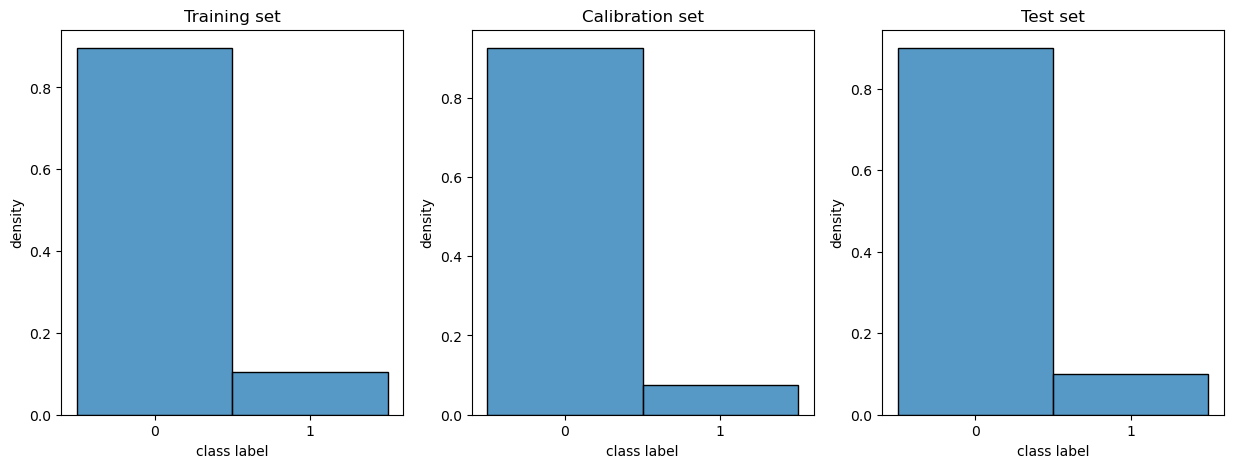

Train set size: (636, 57)
Calibration set size: (160, 57)
Test set size: (199, 57)


In [62]:
# dataset

dataset = pd.read_csv("./dataset/Sepsis_Processed_IC.csv")
X = dataset.drop(columns=['Target'], axis=1)
y = dataset['Target']


# handle datatypes
# drop columns
X.drop(columns=['case_id'], inplace=True)
# convert categorical data to numerical
category_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}
for column in category_columns:
    label_encoders[column] = LabelEncoder()
    X[column] = label_encoders[column].fit_transform(X[column])
# convert bool to int
bool_columns = X.select_dtypes(include=['bool']).columns
for column in bool_columns:
    X[column] = X[column].astype('int')
# convert class labels to numerical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# standardize the data
scaler = RobustScaler()
scaled_columns = ['age', 'max_activity_count', 'duration_since_reg', 'crp', 'lacticacid', 'hours_past_midnight', 'duration_last_event']
X[scaled_columns] = scaler.fit_transform(X[scaled_columns])

# display dataset
pd.set_option('display.max_columns', None)
display(X.head(5))
print("class distribution in the dataset:", np.bincount(y))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_proper, X_cal, y_train_proper, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# plot the class distribution in the training set, calibration set and test set
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(y_train_proper, bins=np.arange(3)-0.5, stat='density', ax=ax[0])
sns.histplot(y_cal, bins=np.arange(3)-0.5, stat='density', ax=ax[1])
sns.histplot(y_test, bins=np.arange(3)-0.5, stat='density', ax=ax[2])
for i in range(3):
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(label_encoder.classes_)
    ax[i].set_xlabel('class label')
    ax[i].set_ylabel('density')
ax[0].set_title('Training set')
ax[1].set_title('Calibration set')
ax[2].set_title('Test set')
plt.show()

# print split sizes
print("Train set size:", X_train_proper.shape)
print("Calibration set size:", X_cal.shape)
print("Test set size:", X_test.shape)

In [63]:
# # rfe = RFE(estimator=clf, n_features_to_select=30)
# rfe = RFECV(estimator=RandomForestClassifier(random_state=42, n_estimators=100, max_depth=4), cv=StratifiedKFold(5), scoring='f1_macro' )
# rfe.fit(X_train_proper, y_train_proper)
# X_train_proper = rfe.transform(X_train_proper)
# X_cal = rfe.transform(X_cal)
# X_test = rfe.transform(X_test)
# print("Selected features:", X_train_proper.shape[1])
# print("Selected features names:", X.columns[rfe.support_])

# select only diagnose feature
X_train_proper = X_train_proper['diagnose'].values.reshape(-1, 1)
X_cal = X_cal['diagnose'].values.reshape(-1, 1)
X_test = X_test['diagnose'].values.reshape(-1, 1)
X_train = X_train['diagnose'].values.reshape(-1, 1)

print("Train set size:", X_train_proper.shape)
print("Calibration set size:", X_cal.shape)
print("Test set size:", X_test.shape)


Train set size: (636, 1)
Calibration set size: (160, 1)
Test set size: (199, 1)


## Model Training and Evaluation

ROC AUC: 0.90
Average Precision: 0.68


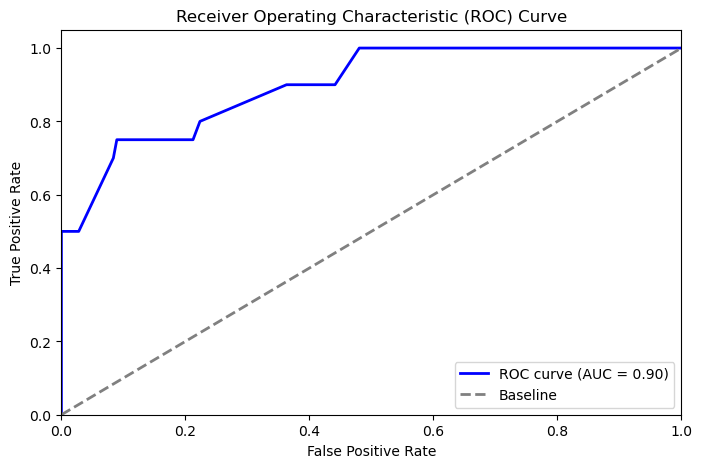

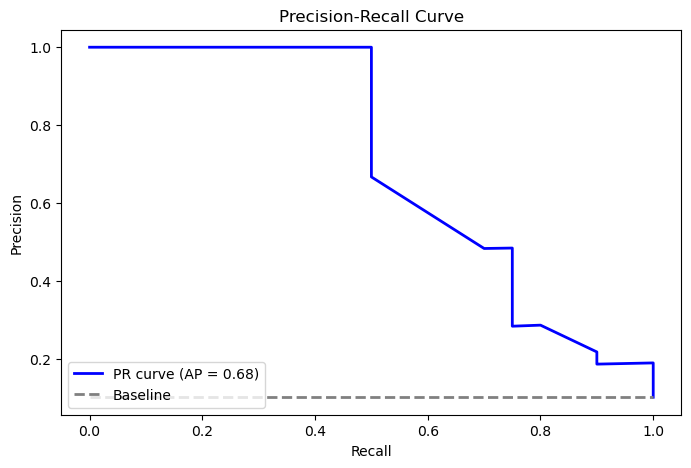

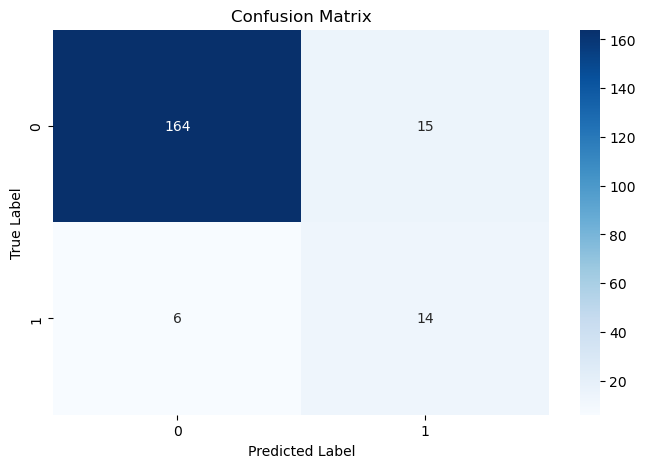

In [64]:
# base model
clf = HistGradientBoostingClassifier(random_state=42, scoring='f1_macro', max_iter=500, class_weight={0: 1, 1: 6}, learning_rate=0.01)
clf.fit(X_train_proper, y_train_proper)
prediction_prob_test = clf.predict_proba(X_test)
predictions = clf.predict(X_test)

# evaluation
roc_auc = roc_auc_score(y_test, prediction_prob_test[:,1])
print(f"ROC AUC: {roc_auc:.2f}")
average_precision = average_precision_score(y_test, prediction_prob_test[:,1])
print(f"Average Precision: {average_precision:.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob_test[:,1])
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, prediction_prob_test[:, 1])
baseline = len(y_test[y_test==1]) / len(y_test) # ratio of positive class
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# confusion matrix
# threshold = 0.1
# predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

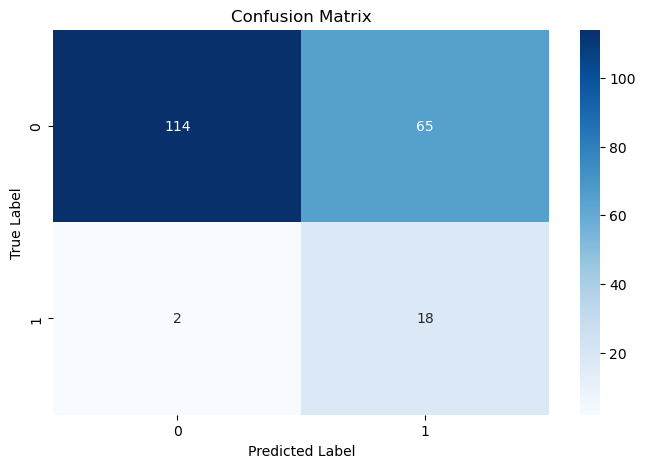

In [5]:
threshold = 0.3
predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##### Nonconformist Library

Coverage: 0.899
Average Set Width: 1.13


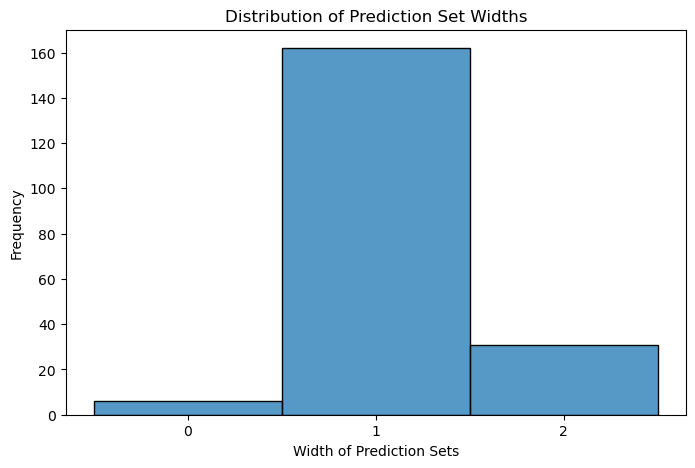

Indices with zero width:  [43, 82, 106, 110, 135, 157]


In [66]:
# using Transductive Conformal Prediction
nc = NcFactory.create_nc(clf, err_func=InverseProbabilityErrFunc())
tcp = TcpClassifier(nc)

tcp.fit(X_train, y_train)

predictions = tcp.predict(X_test, significance=0.1) # significance level 0.1
# print("1st output of predictions: ",predictions[0])


# evaluation
coverage = np.mean([predictions[i][y_test[i]] for i in range(len(y_test))]) 
widths = [np.sum(pred) for pred in predictions]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.3f}")
print(f"Average Set Width: {average_width:.2f}")
# print(classification_report(y_test, [np.argmax(pred) for pred in predictions]))

# # Plot distribution of predictive set sizes
# plt.figure(figsize=(8, 5))
# sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
# plt.xticks([0, 1, 2])
# plt.xlabel('Width of Prediction Sets')
# plt.ylabel('Frequency')
# plt.title('Distribution of Prediction Set Widths')
# # plt.grid(True)
# plt.show()

# # indices with zero width
# zero_width_indices_nonconformist = [i for i in range(len(widths)) if widths[i] == 0]
# print("Indices with zero width: ", zero_width_indices_nonconformist)

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10')
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths')
plt.show()

# plot prediction set widths by predicted class label
data = {'widths': widths, 'Class': predictions}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Predicted Class Label')
plt.show()


# plot prediction set widths by confusion matrix category
cm_labels = []
for true, pred in zip(y_test, predictions):
    if true == 1 and pred == 1:
        cm_labels.append('TP')  # True Positive
    elif true == 0 and pred == 0:
        cm_labels.append('TN')  # True Negative
    elif true == 0 and pred == 1:
        cm_labels.append('FP')  # False Positive
    elif true == 1 and pred == 0:
        cm_labels.append('FN')  # False Negative
data = {'widths': widths, 'Confusion Matrix': cm_labels}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Confusion Matrix', multiple='stack', discrete=True, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='hls')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Confusion Matrix Category')
plt.show()


# plot prediction set widths by true class label
data = {'widths': widths, 'Class': y_test}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by True Class Label')
plt.show()

# indices in predictions where width is 0
# zero_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 0]
# print("Indices where width is 0: ",zero_width_indices_crepes)

# indices in predictions where width is 2
two_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 2]
print("Indices where width is 0: ",two_width_indices_crepes)


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob_test[:,1])
roc_auc = roc_auc_score(y_test, prediction_prob_test[:,1])
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

# plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, prediction_prob_test[:, 1])
average_precision = average_precision_score(y_test, prediction_prob_test[:, 1])
baseline = len(y_test[y_test==1]) / len(y_test) # ratio of positive class
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# confusion matrix
# threshold = 0.1
# predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

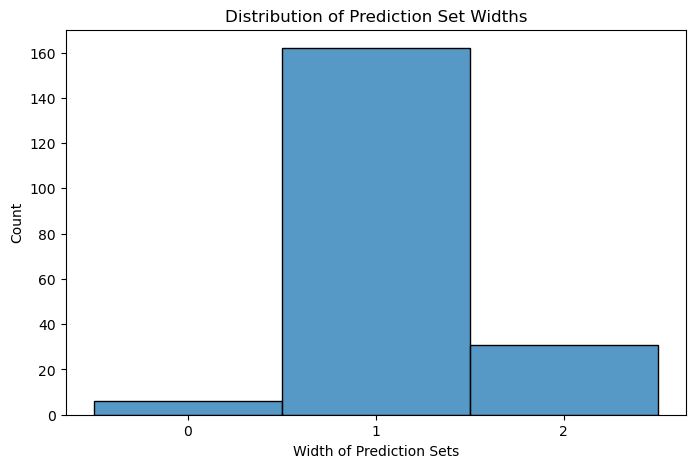

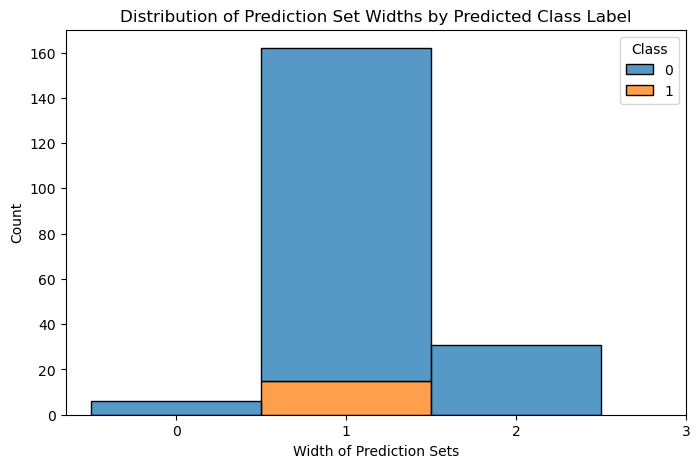

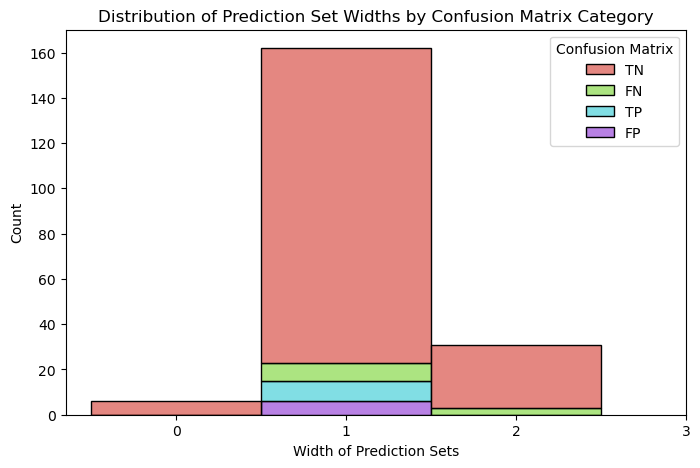

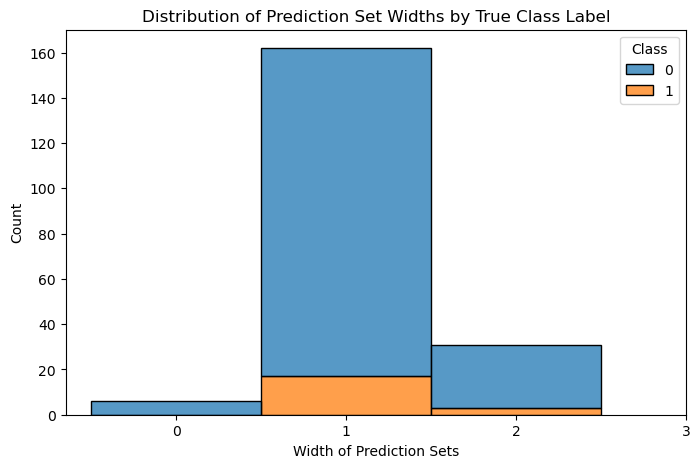

Indices where width is 0:  [43, 82, 106, 110, 135, 157]
Indices where width is 0:  [2, 5, 7, 8, 9, 18, 25, 33, 39, 53, 56, 66, 69, 71, 77, 78, 97, 111, 119, 125, 130, 137, 158, 170, 173, 181, 183, 184, 195, 197, 198]


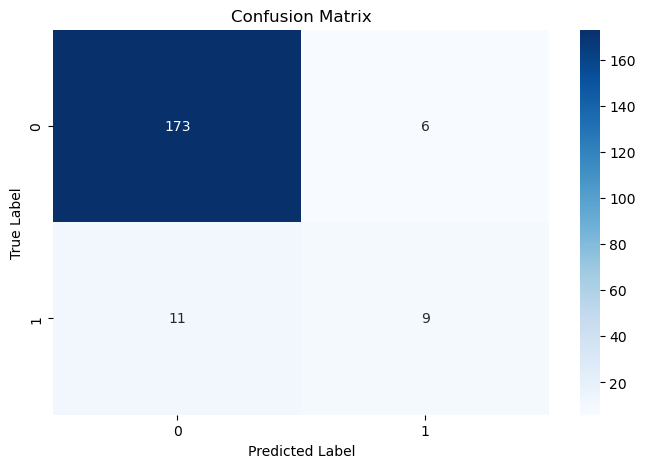

In [90]:
prediction_sets = predictions
predictions = np.argmax(predictions, axis=1)

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10')
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths')
plt.show()

# plot prediction set widths by predicted class label
data = {'widths': widths, 'Class': predictions}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Predicted Class Label')
plt.show()


# plot prediction set widths by confusion matrix category
cm_labels = []
for true, pred in zip(y_test, predictions):
    if true == 1 and pred == 1:
        cm_labels.append('TP')  # True Positive
    elif true == 0 and pred == 0:
        cm_labels.append('TN')  # True Negative
    elif true == 0 and pred == 1:
        cm_labels.append('FP')  # False Positive
    elif true == 1 and pred == 0:
        cm_labels.append('FN')  # False Negative
data = {'widths': widths, 'Confusion Matrix': cm_labels}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Confusion Matrix', multiple='stack', discrete=True, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='hls')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Confusion Matrix Category')
plt.show()


# plot prediction set widths by true class label
data = {'widths': widths, 'Class': y_test}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by True Class Label')
plt.show()

# indices in predictions where width is 0
zero_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 0]
print("Indices where width is 0: ",zero_width_indices_crepes)

# indices in predictions where width is 2
two_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 2]
print("Indices where width is 0: ",two_width_indices_crepes)


# confusion matrix
# threshold = 0.1
# predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##### Crepes Library

Coverage: 0.94
Average Set Width: 1.07


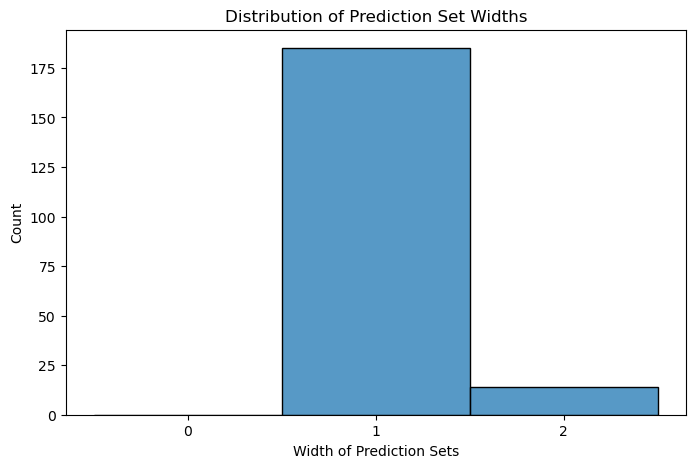

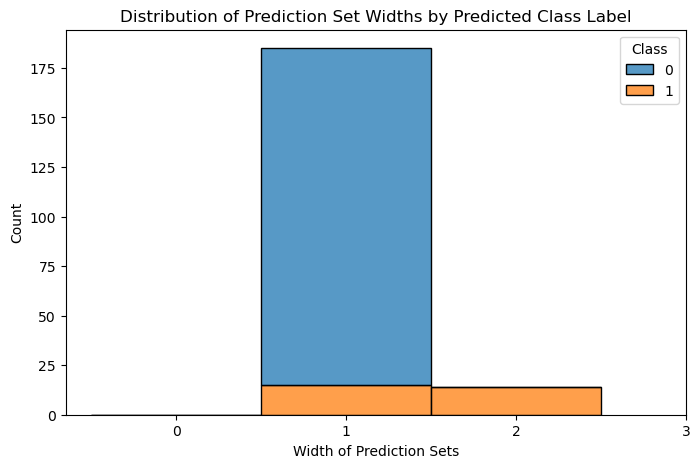

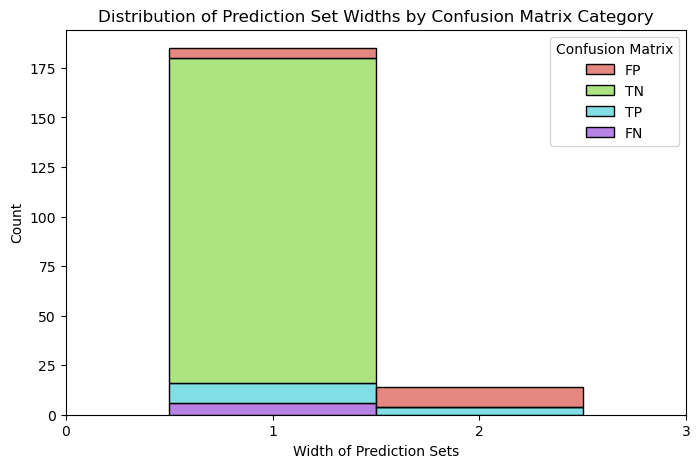

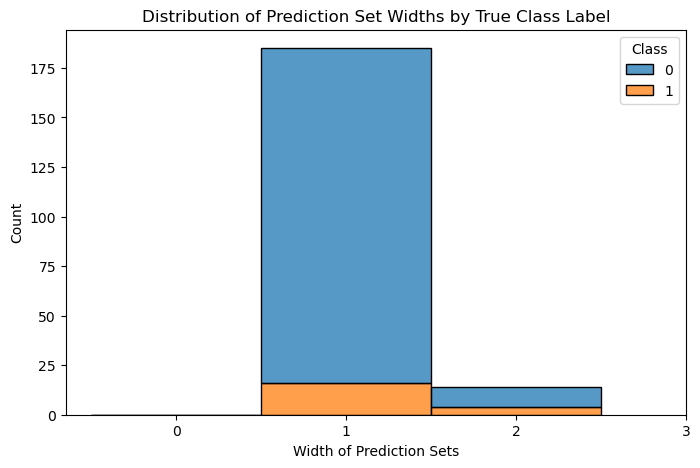

Indices where width is 0:  [0, 22, 35, 45, 67, 91, 99, 102, 105, 122, 143, 155, 162, 188]


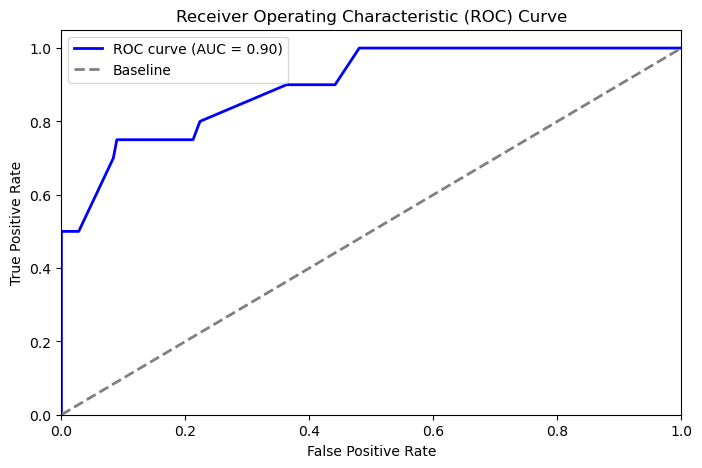

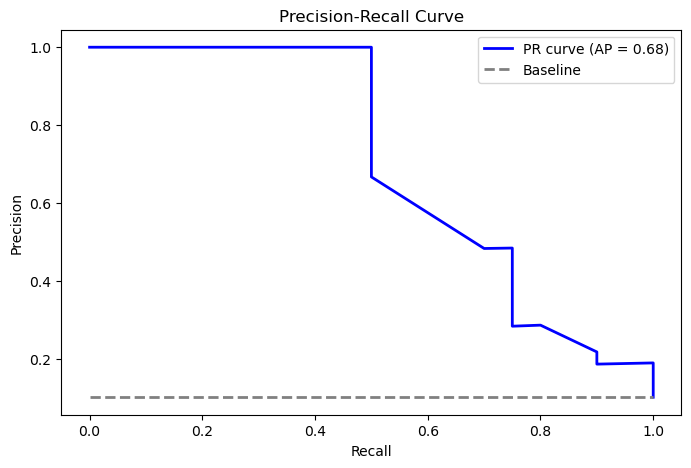

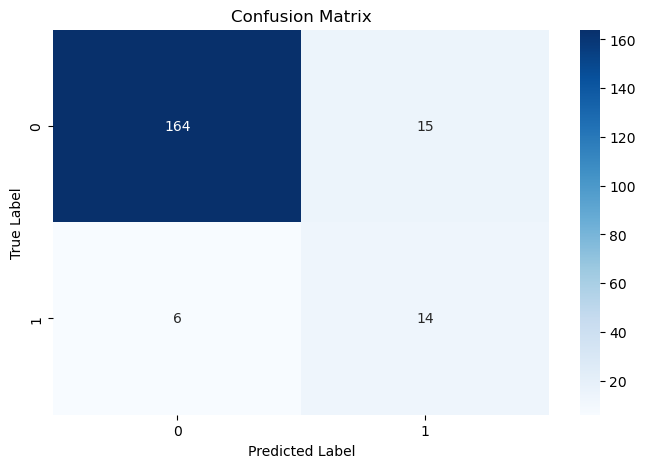

In [6]:
wrapped_clf = WrapClassifier(clf)

wrapped_clf.calibrate(X_cal, y_cal)

prediction_sets = wrapped_clf.predict_set(X_test, confidence=0.9) # significance level 0.1
predictions = wrapped_clf.predict(X_test)
prediction_prob_test = wrapped_clf.predict_proba(X_test)

# print("1st output of prediction_sets: ",prediction_sets[0])
# print(prediction_sets.shape)


# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(prediction_sets))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

# result = wrapped_clf.evaluate(X_test, y_test, confidence=0.9)
# print(result)
# print(classification_report(y_test, predictions))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10')
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths')
plt.show()

# plot prediction set widths by predicted class label
data = {'widths': widths, 'Class': predictions}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Predicted Class Label')
plt.show()


# plot prediction set widths by confusion matrix category
cm_labels = []
for true, pred in zip(y_test, predictions):
    if true == 1 and pred == 1:
        cm_labels.append('TP')  # True Positive
    elif true == 0 and pred == 0:
        cm_labels.append('TN')  # True Negative
    elif true == 0 and pred == 1:
        cm_labels.append('FP')  # False Positive
    elif true == 1 and pred == 0:
        cm_labels.append('FN')  # False Negative
data = {'widths': widths, 'Confusion Matrix': cm_labels}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Confusion Matrix', multiple='stack', discrete=True, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='hls')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Confusion Matrix Category')
plt.show()


# plot prediction set widths by true class label
data = {'widths': widths, 'Class': y_test}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by True Class Label')
plt.show()

# indices in predictions where width is 0
# zero_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 0]
# print("Indices where width is 0: ",zero_width_indices_crepes)

# indices in predictions where width is 2
two_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 2]
print("Indices where width is 0: ",two_width_indices_crepes)


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob_test[:,1])
roc_auc = roc_auc_score(y_test, prediction_prob_test[:,1])
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

# plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, prediction_prob_test[:, 1])
average_precision = average_precision_score(y_test, prediction_prob_test[:, 1])
baseline = len(y_test[y_test==1]) / len(y_test) # ratio of positive class
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# confusion matrix
# threshold = 0.1
# predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Coverage: 0.94
Average Set Width: 1.07
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       179
           1       0.48      0.70      0.57        20

    accuracy                           0.89       199
   macro avg       0.72      0.81      0.76       199
weighted avg       0.92      0.89      0.90       199



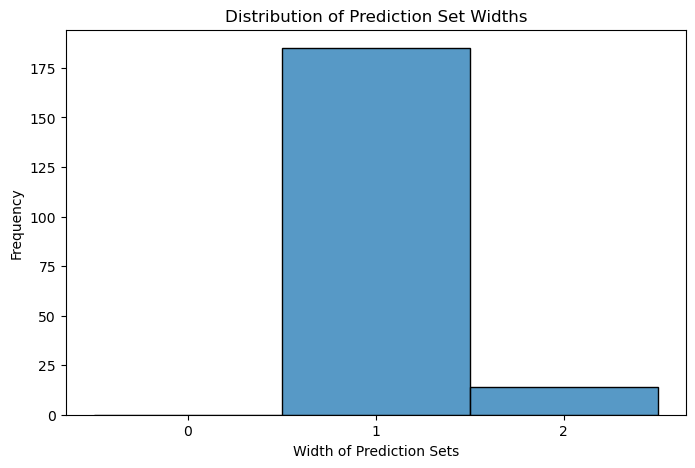

In [20]:
# Mondrian conformal classifiers Class-conditional
wrapped_clf = WrapClassifier(clf)

rf_class_cond = WrapClassifier(wrapped_clf.learner)
wrapped_clf = rf_class_cond
wrapped_clf.calibrate(X_cal, y_cal, class_cond=True)

prediciton_sets = wrapped_clf.predict_set(X_test, confidence=0.9) # significance level 0.1
predictions = wrapped_clf.predict(X_test)

# print(prediciton_sets[:5])
# print(prediciton_sets.shape)

# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(y_test))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

wrapped_clf.evaluate(X_test, y_test, confidence=0.9)
print(classification_report(y_test, predictions))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False)
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Set Widths')
# plt.grid(True)
plt.show()

##### Venn Abers Library

,p0,p1,p of class_1,y
0,0.058824,0.088235,0.085714,0
1,0.017241,0.025862,0.025641,0
2,0.017241,0.025862,0.025641,0
3,0.017241,0.025862,0.025641,0
4,0.017241,0.025862,0.025641,0
5,0.017241,0.025862,0.025641,0
6,0.017241,0.025862,0.025641,0
7,0.058824,0.088235,0.085714,0
8,0.017241,0.025862,0.025641,0
9,0.058824,0.088235,0.085714,0


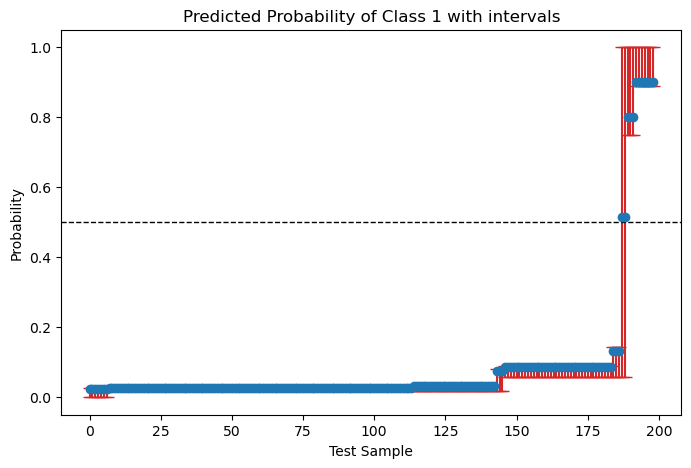

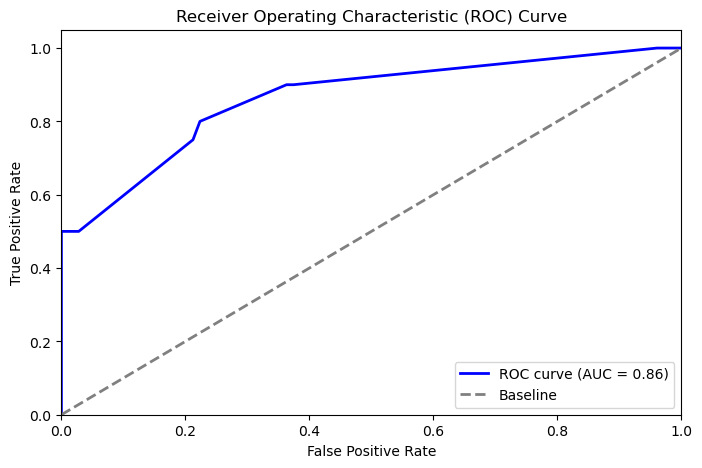

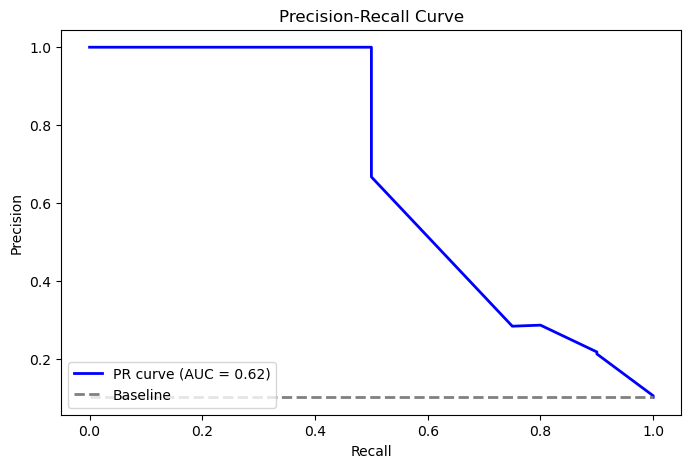

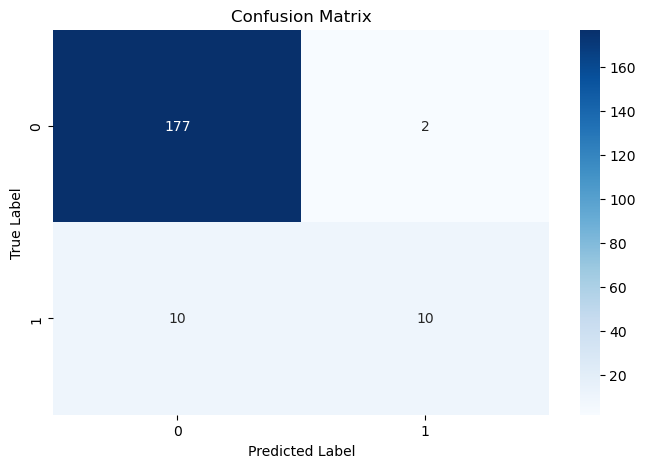

In [23]:
prediction_prob_cal = clf.predict_proba(X_cal)
prediction_prob_test = clf.predict_proba(X_test)
y_pred_noncal = clf.predict(X_test)

va = VennAbersCalibrator()
p_prime = va.predict_proba(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test, p0_p1_output=True) # probability intervals for class 1
y_pred = va.predict(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test) # predicted class labels

# convert to class labels
y_pred = np.argmax(y_pred, axis=1)

# evaluation
# coverage = np.mean([p_prime[0][i][y_test[i]] <= p_prime[1][i][y_test[i]] for i in range(len(y_test))])
# print(f"Coverage: {coverage:.2f}")
# print(classification_report(y_test, y_pred))


# plot prediction probabilities with intervals
y_pred_interval_p1 = p_prime[1]
y_pred_p1 = p_prime[0][:, 1]

# create dataframe using p0 and p1
df = pd.DataFrame({'p0': y_pred_interval_p1[:,0], 'p1': y_pred_interval_p1[:,1], 'p of class_1': y_pred_p1, 'y': y_test})
display(df.head(10))


# sort the predicted probabilities
sorted_indices = np.argsort(y_pred_p1)
y_pred_interval_p1 = y_pred_interval_p1[sorted_indices]
y_pred_p1 = y_pred_p1[sorted_indices]
y_test_sorted = y_test[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
lower_bound = y_pred_p1 - y_pred_interval_p1[:, 0]
upper_bound = y_pred_interval_p1[:, 1] - y_pred_p1
bounds = [lower_bound, upper_bound]

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='tab:red', capsize=5, label='Predicted Probability of Class 1')
# plt.scatter(np.arange(len(y_pred_p1)), y_test_sorted, color='tab:blue', label='Actual Label')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals')
# plt.legend()
plt.show()

# plot roc curve
fpr, tpr, _ = roc_curve(y_test_sorted, y_pred_p1)
roc_auc = roc_auc_score(y_test_sorted, y_pred_p1)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# plot precision-recall curve
baseline = len(y_test_sorted[y_test_sorted==1]) / len(y_test_sorted) # ratio of positive class
precision, recall, _ = precision_recall_curve(y_test_sorted, y_pred_p1)
average_precision = average_precision_score(y_test_sorted, y_pred_p1)
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {average_precision:.2f})')
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# confusion matrix
# threshold = 0.5
# predictions = (y_pred_p1 >= threshold).astype(int)
cm = confusion_matrix(y_test_sorted, y_pred_sorted)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# test set for indices with width two
X_test_new = X_test.iloc[zero_width_indices_nonconformist]
y_test_new = y_test[zero_width_indices_nonconformist]
print("Test set size for indices with zero width using nonconformist transductive method: ",X_test_new.shape)

# plot prediction probabilities with intervals
y_pred_interval_p1 = p_prime[1]
y_pred_p1 = p_prime[0][:, 1]
# keep only the values with zero width
y_pred_interval_p1 = y_pred_interval_p1[zero_width_indices_nonconformist]
y_pred_p1 = y_pred_p1[zero_width_indices_nonconformist]

# create dataframe using p0 and p1
df = pd.DataFrame({'p0': y_pred_interval_p1[:,0], 'p1': y_pred_interval_p1[:,1], 'p of class_1': y_pred_p1, 'y': y_test_new})
display(df.head(20))


# sort the predicted probabilities
sorted_indices = np.argsort(y_pred_p1)
y_pred_interval_p1 = y_pred_interval_p1[sorted_indices]
y_pred_p1 = y_pred_p1[sorted_indices]
y_test_sorted = y_test[sorted_indices]
lower_bound = y_pred_p1 - y_pred_interval_p1[:, 0]
upper_bound = y_pred_interval_p1[:, 1] - y_pred_p1
bounds = [lower_bound, upper_bound]

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='tab:red', capsize=5, label='Predicted Probability of Class 1')
# plt.scatter(np.arange(len(y_pred_p1)), y_test_sorted, color='tab:blue', label='Actual Label')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals')
# plt.legend()
plt.show()

Test set size for indices with width two for crepes inductive method:  (14, 1)


,p0,p1,p of class_1,y_pred,y
0,0.058824,0.088235,0.085714,0.0,0
1,0.058824,0.088235,0.085714,0.0,1
2,0.058824,0.088235,0.085714,0.0,1
3,0.058824,0.088235,0.085714,0.0,0
4,0.058824,0.088235,0.085714,0.0,0
5,0.058824,0.088235,0.085714,0.0,0
6,0.058824,0.088235,0.085714,0.0,0
7,0.058824,0.088235,0.085714,0.0,0
8,0.058824,0.088235,0.085714,0.0,0
9,0.058824,0.088235,0.085714,0.0,0


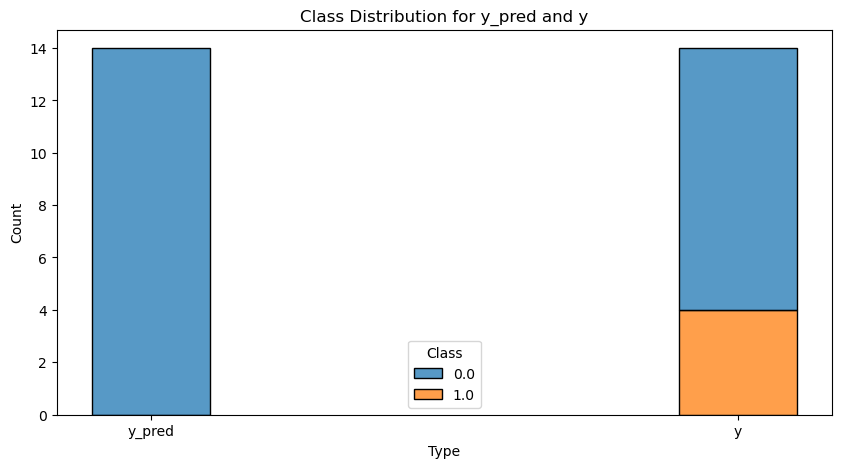

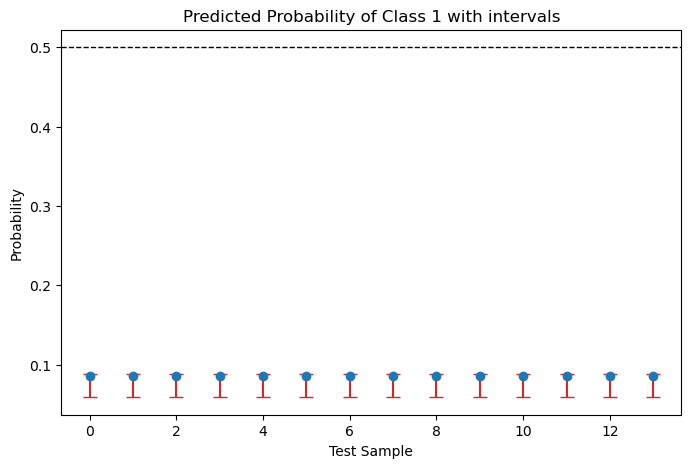

In [52]:
# test set for indices with zero width
X_test_new = X_test[two_width_indices_crepes]
y_test_new = y_test[two_width_indices_crepes]
print("Test set size for indices with width two for crepes inductive method: ",X_test_new.shape)


# plot prediction probabilities with intervals
y_pred_interval_p1 = p_prime[1]
y_pred_p1 = p_prime[0][:, 1]
# keep only the values with width two
y_pred_interval_p1 = y_pred_interval_p1[two_width_indices_crepes]
y_pred_p1 = y_pred_p1[two_width_indices_crepes]
y_pred = np.floor(y_pred_p1 + 0.5)

# create dataframe using p0 and p1
df = pd.DataFrame({'p0': y_pred_interval_p1[:,0], 'p1': y_pred_interval_p1[:,1], 'p of class_1': y_pred_p1, 'y_pred': y_pred, 'y': y_test_new})
display(df.head(20))

# plot y_pred and y
df_melted = pd.melt(df[['y_pred', 'y']], var_name='Type', value_name='Class')
plt.figure(figsize=(10, 5))
sns.histplot(data=df_melted, x='Type', hue='Class', multiple='stack', shrink=0.2, palette='tab10')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Class Distribution for y_pred and y')
plt.show()



# sort the predicted probabilities
sorted_indices = np.argsort(y_pred_p1)
y_pred_interval_p1 = y_pred_interval_p1[sorted_indices]
y_pred_p1 = y_pred_p1[sorted_indices]
y_test_sorted = y_test[sorted_indices]
lower_bound = y_pred_p1 - y_pred_interval_p1[:, 0]
upper_bound = y_pred_interval_p1[:, 1] - y_pred_p1
bounds = [lower_bound, upper_bound]

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='tab:red', capsize=5, label='Predicted Probability of Class 1')
# plt.scatter(np.arange(len(y_pred_p1)), y_test_sorted, color='tab:blue', label='Actual Label')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals')
# plt.legend()
plt.show()

[187  12]
ROC AUC: 0.86
Average Precision: 0.62


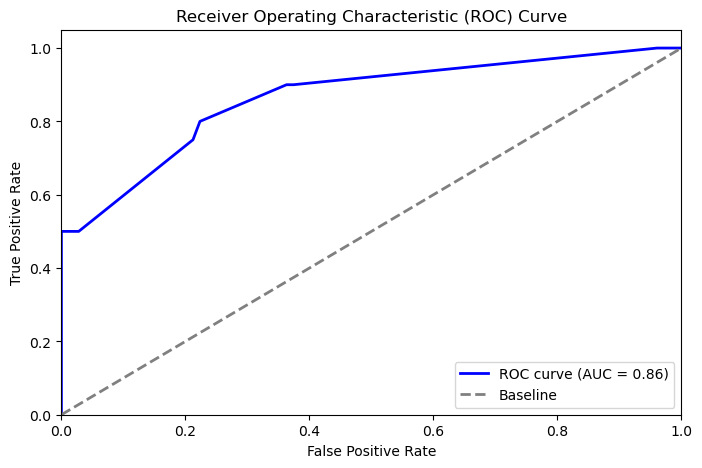

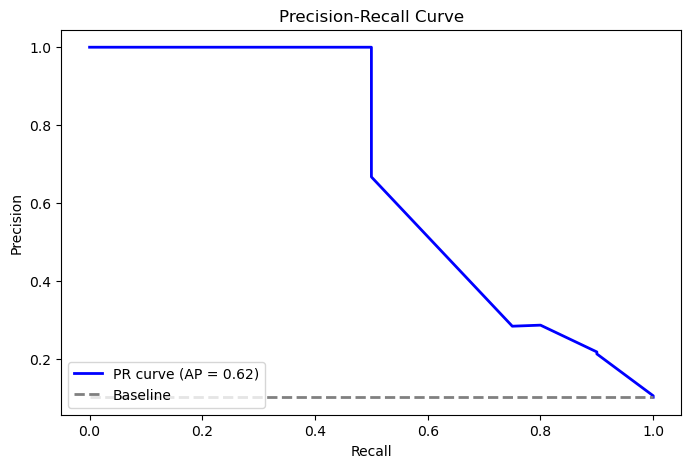

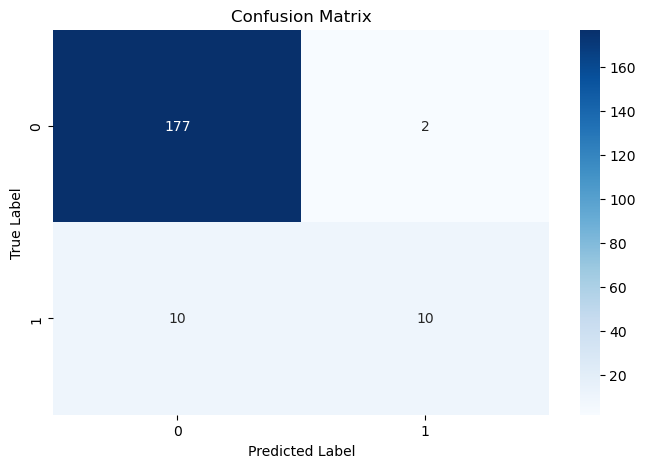

In [43]:
prediction_prob_cal = clf.predict_proba(X_cal)
prediction_prob_test = clf.predict_proba(X_test)
y_pred_noncal = clf.predict(X_test)

va = VennAbersCalibrator()
p_prime = va.predict_proba(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test, p0_p1_output=True) # probability intervals for class 1
y_pred = va.predict(p_cal=prediction_prob_cal, y_cal=y_cal, p_test=prediction_prob_test) # predicted class labels
predictions = np.argmax(y_pred, axis=1) # convert to class labels
prediction_prob_test = p_prime[0][:, 1]

# evaluation
roc_auc = roc_auc_score(y_test, prediction_prob_test)
print(f"ROC AUC: {roc_auc:.2f}")
average_precision = average_precision_score(y_test, prediction_prob_test)
print(f"Average Precision: {average_precision:.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob_test)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, prediction_prob_test)
baseline = len(y_test[y_test==1]) / len(y_test) # ratio of positive class
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# confusion matrix
# threshold = 0.1
# predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Coverage: 0.94
Average Set Width: 1.07


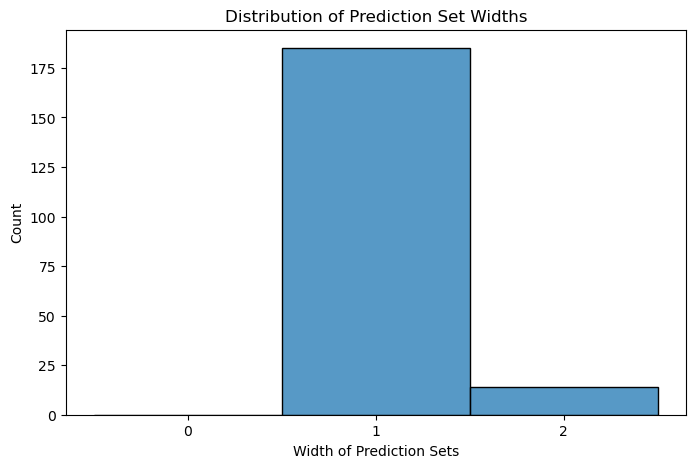

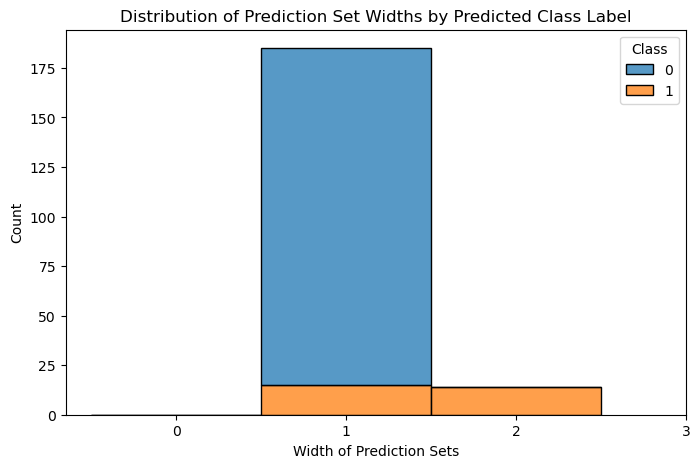

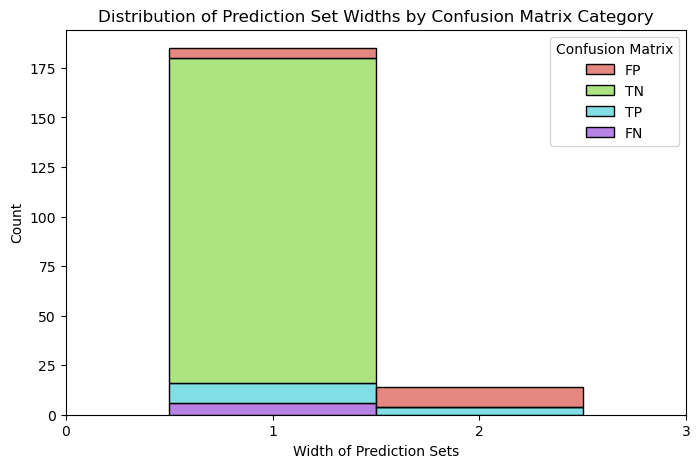

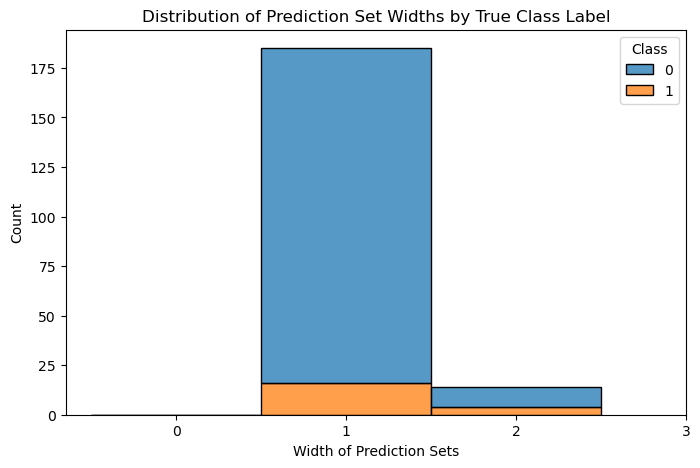

Indices where width is 0:  [0, 22, 35, 45, 67, 91, 99, 102, 105, 122, 143, 155, 162, 188]


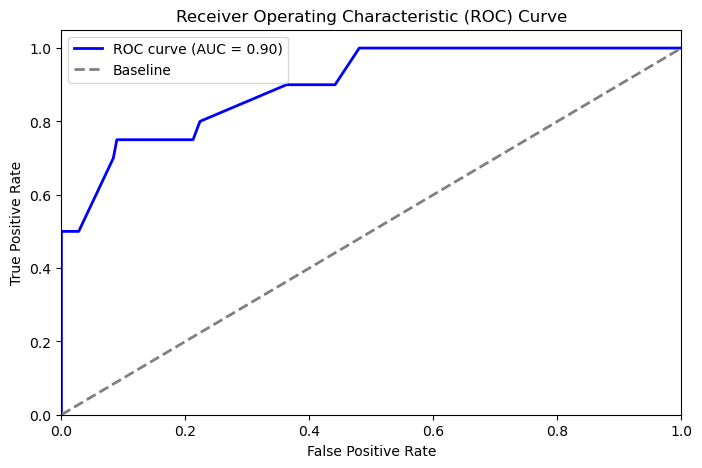

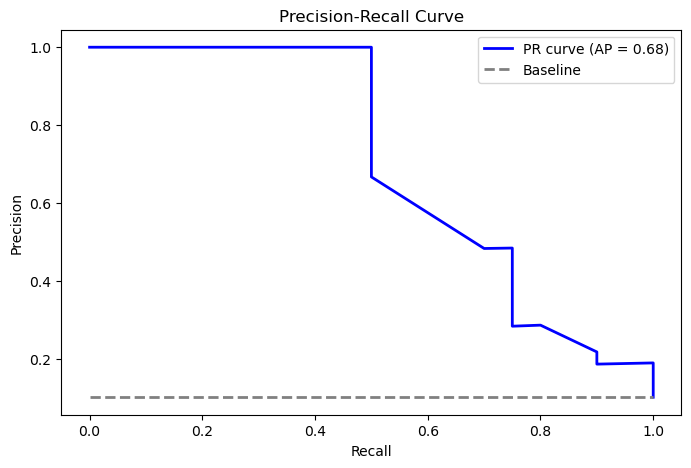

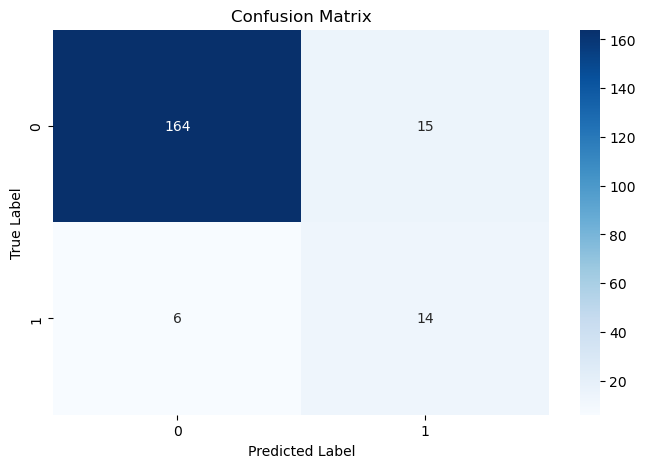

In [51]:
wrapped_clf = WrapClassifier(clf)

wrapped_clf.calibrate(X_cal, y_cal)

prediction_sets = wrapped_clf.predict_set(X_test, confidence=0.9) # significance level 0.1
predictions = wrapped_clf.predict(X_test)
prediction_prob_test = wrapped_clf.predict_proba(X_test)

# print("1st output of prediction_sets: ",prediction_sets[0])
# print(prediction_sets.shape)


# evaluation
coverage = np.mean([prediction_sets[i][y_test[i]] for i in range(len(prediction_sets))])
widths = [np.sum(pred) for pred in prediction_sets]
average_width = np.mean(widths)

print(f"Coverage: {coverage:.2f}")
print(f"Average Set Width: {average_width:.2f}")

# result = wrapped_clf.evaluate(X_test, y_test, confidence=0.9)
# print(result)
# print(classification_report(y_test, predictions))

# Plot distribution of predictive set sizes
plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10')
plt.xticks([0, 1, 2])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths')
plt.show()

# plot prediction set widths by predicted class label
data = {'widths': widths, 'Class': predictions}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Predicted Class Label')
plt.show()


# plot prediction set widths by confusion matrix category
cm_labels = []
for true, pred in zip(y_test, predictions):
    if true == 1 and pred == 1:
        cm_labels.append('TP')  # True Positive
    elif true == 0 and pred == 0:
        cm_labels.append('TN')  # True Negative
    elif true == 0 and pred == 1:
        cm_labels.append('FP')  # False Positive
    elif true == 1 and pred == 0:
        cm_labels.append('FN')  # False Negative
data = {'widths': widths, 'Confusion Matrix': cm_labels}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Confusion Matrix', multiple='stack', discrete=True, bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='hls')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by Confusion Matrix Category')
plt.show()


# plot prediction set widths by true class label
data = {'widths': widths, 'Class': y_test}
data_df = pd.DataFrame(data)
plt.figure(figsize=(8, 5))
sns.histplot(data=data_df, x='widths', hue='Class', bins=np.arange(0, 4) - 0.5, edgecolor='black', kde=False, palette='tab10', multiple='stack')
plt.xticks([0, 1, 2, 3])
plt.xlabel('Width of Prediction Sets')
plt.ylabel('Count')
plt.title('Distribution of Prediction Set Widths by True Class Label')
plt.show()

# indices in predictions where width is 0
# zero_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 0]
# print("Indices where width is 0: ",zero_width_indices_crepes)

# indices in predictions where width is 2
two_width_indices_crepes = [i for i in range(len(prediction_sets)) if np.sum(prediction_sets[i]) == 2]
print("Indices where width is 0: ",two_width_indices_crepes)


# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, prediction_prob_test[:,1])
roc_auc = roc_auc_score(y_test, prediction_prob_test[:,1])
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()

# plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, prediction_prob_test[:, 1])
average_precision = average_precision_score(y_test, prediction_prob_test[:, 1])
baseline = len(y_test[y_test==1]) / len(y_test) # ratio of positive class
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.plot([0, 1], [baseline, baseline], color='gray', lw=2, linestyle='--', label='Baseline')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# confusion matrix
# threshold = 0.1
# predictions = (prediction_prob_test[:, 1] >= threshold).astype(int)
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

,p0,p1,p of class_1,y_pred,y
0,0.058824,0.088235,0.085714,0,0
1,0.017241,0.025862,0.025641,0,0
2,0.017241,0.025862,0.025641,0,0
3,0.017241,0.025862,0.025641,0,0
4,0.017241,0.025862,0.025641,0,0
5,0.017241,0.025862,0.025641,0,0
6,0.017241,0.025862,0.025641,0,0
7,0.058824,0.088235,0.085714,0,0
8,0.017241,0.025862,0.025641,0,0
9,0.058824,0.088235,0.085714,0,0


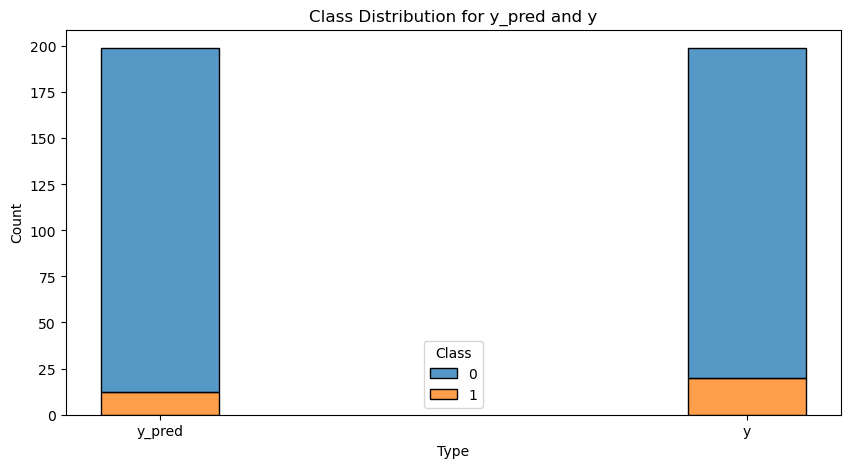

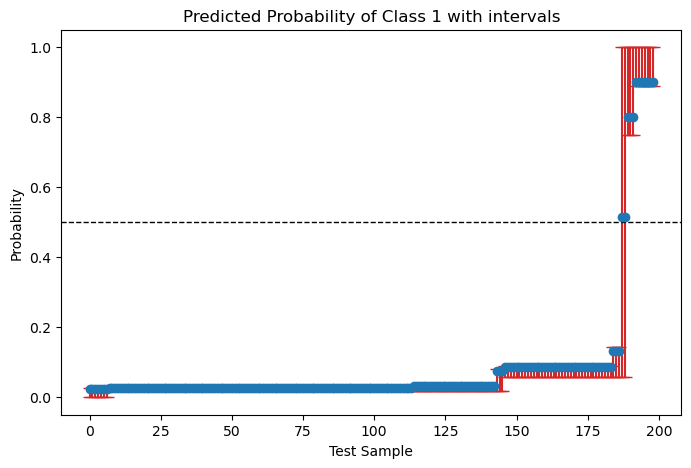

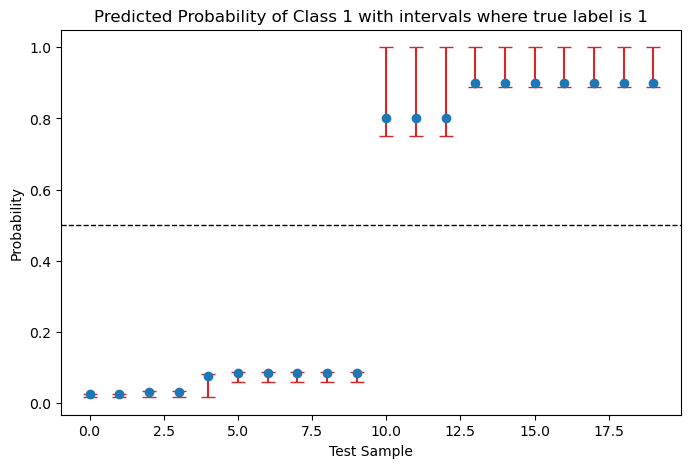

In [50]:
# plot prediction probabilities with intervals
y_pred_interval_p1 = p_prime[1]
y_pred_p1 = p_prime[0][:, 1]


# create dataframe using p0 and p1
df = pd.DataFrame({'p0': y_pred_interval_p1[:,0], 'p1': y_pred_interval_p1[:,1], 'p of class_1': y_pred_p1, 'y_pred': predictions, 'y': y_test})
display(df.head(20))

# plot y_pred and y
df_melted = pd.melt(df[['y_pred', 'y']], var_name='Type', value_name='Class')
plt.figure(figsize=(10, 5))
sns.histplot(data=df_melted, x='Type', hue='Class', multiple='stack', shrink=0.2, palette='tab10')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Class Distribution for y_pred and y')
plt.show()



# sort the predicted probabilities
sorted_indices = np.argsort(y_pred_p1)
y_pred_interval_p1 = y_pred_interval_p1[sorted_indices]
y_pred_p1 = y_pred_p1[sorted_indices]
y_test_sorted = y_test[sorted_indices]
predictions = predictions[sorted_indices]
lower_bound = y_pred_p1 - y_pred_interval_p1[:, 0]
upper_bound = y_pred_interval_p1[:, 1] - y_pred_p1
bounds = [lower_bound, upper_bound]

# plot prediction probabilities with intervals
plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='tab:red', capsize=5, label='Predicted Probability of Class 1')
# plt.scatter(np.arange(len(y_pred_p1)), y_test_sorted, color='tab:blue', label='Actual Label')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals')
# plt.legend()
plt.show()

# plot prediction probabilities with intervals where y_pred is 1
y_pred_interval_p1 = y_pred_interval_p1[y_test_sorted == 1]
y_pred_p1 = y_pred_p1[y_test_sorted == 1]
y_test_sorted = y_test_sorted[y_test_sorted == 1]
lower_bound = y_pred_p1 - y_pred_interval_p1[:, 0]
upper_bound = y_pred_interval_p1[:, 1] - y_pred_p1
bounds = [lower_bound, upper_bound]

# plot prediction probabilities with intervals
plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(len(y_pred_p1)), y_pred_p1, yerr=bounds, fmt='o', ecolor='tab:red', capsize=5, label='Predicted Probability of Class 1')
# plt.scatter(np.arange(len(y_pred_p1)), y_test_sorted, color='tab:blue', label='Actual Label')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.ylabel('Probability')
plt.xlabel('Test Sample')
plt.title('Predicted Probability of Class 1 with intervals where true label is 1')
# plt.legend()
plt.show()

